In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    auc
)
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")
os.chdir("/net/trapnell/vol1/home/mdcolon/proj/fishcaster/")

#this is the function that is used to save the paths, they are used the same way in all functions
#change this function so you can save them in the way you want. 
def results_path(sub_directory):
    """Creates a directory path with the current date and sub-directory."""
    today = datetime.now()
    month_year = today.strftime("%m_%Y")
    date = today.strftime("%m_%d_%Y")
    path = os.path.join('results', month_year, date, sub_directory)
    os.makedirs(path, exist_ok=True)  # Create directory if not exists
    return path


# Processing two Data Files

In [2]:
#Download Data
df_all_path = "./data/embryo_morph_df.csv"
df_hld_path = "./data/embryo_stats_no_lmx1b_gdf3_df.csv"

df_all = pd.read_csv(df_all_path)
df_hld = pd.read_csv(df_hld_path)

# Update 'master_perturbation' values to 'Shh' where it contains 'Shh'
for df in [df_all, df_hld]:
    df.loc[df["master_perturbation"].str.contains("Shh"), "master_perturbation"] = "Shh"

# Define the comparisons (Multiclass) and obtain coloumns for data
pert_comparisons = ["Wnt-i", "TGFB-i", "wik", "lmx1b", "gdf3"]
z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

In [3]:
def ensure_embryo_id_column(df):
    """
    Ensures the 'embryo_id' column exists in the dataframe by extracting it from the 'snip_id' column.
    If 'embryo_id' already exists, no changes are made.
    
    Parameters:
    df (pd.DataFrame): The dataframe that may contain the 'snip_id' and 'embryo_id' columns.
    
    Returns:
    df (pd.DataFrame): The dataframe with the 'embryo_id' column ensured.
    """
    if 'embryo_id' not in df.columns:
        try:
            df['embryo_id'] = df['snip_id'].str.replace(r'_[^_]*$', '', regex=True)
        except KeyError as e:
            raise KeyError("'snip_id' column not found in the dataframe") from e
    return df

def split_train_test(df, test_size=0.2, random_state=42):
    """
    Splits a dataframe into training and test sets based on unique 'embryo_id'.

    Parameters:
    df (pd.DataFrame): The dataframe containing the 'embryo_id' column.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): The random seed for reproducibility.

    Returns:
    train_df (pd.DataFrame): The training dataframe.
    test_df (pd.DataFrame): The test dataframe.
    """
    df = ensure_embryo_id_column(df)
    unique_embryo_ids = df["embryo_id"].unique()
    train_ids, test_ids = train_test_split(unique_embryo_ids, test_size=test_size, random_state=random_state)
    train_df = df[df["embryo_id"].isin(train_ids)].reset_index(drop=True)
    test_df = df[df["embryo_id"].isin(test_ids)].reset_index(drop=True)
    
    return train_df, test_df, df

In [4]:
# Split the data
df_all_train, df_all_test, df_all = split_train_test(df_all)
df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)

# Logistic Multiclass Regression, and balanced

In [5]:

def logistic_regression_multiclass(train_df, test_df, z_mu_biological_columns, pert_comparisons, tol=1e-3, balanced=False):
    """
    Perform logistic regression for a multiclass classification problem.

    Parameters:
    - train_df (pd.DataFrame): Training DataFrame.
    - test_df (pd.DataFrame): Test DataFrame.
    - z_mu_biological_columns (list): List of feature column names.
    - pert_comparisons (list): List of perturbation class names.
    - tol (float): Tolerance for stopping criteria. Defaults to 1e-3.
    - balanced (bool): Whether to balance the classes in training and test sets. Defaults to False.

    Returns:
    - y_test (np.ndarray): True labels for the test set.
    - y_pred_proba (np.ndarray): Predicted probabilities for the test set.
    - log_reg (LogisticRegression): Trained Logistic Regression model.
    - train_df (pd.DataFrame): Modified training DataFrame with 'class_num'.
    - test_df (pd.DataFrame): Modified test DataFrame with 'class_num'.
    """
    # Create a mapping for the perturbations to integer labels
    perturbation_to_label = {pert: int(i) for i, pert in enumerate(pert_comparisons)}

    # Add 'class_num' column to both train_df and test_df
    train_df['class_num'] = train_df['master_perturbation'].map(perturbation_to_label)
    test_df['class_num'] = test_df['master_perturbation'].map(perturbation_to_label)

    # Remove any rows where class_num is NaN
    train_df = train_df.dropna(subset=['class_num'])
    test_df = test_df.dropna(subset=['class_num'])

    # After mapping 'class_num' and dropping NaNs
    train_df['class_num'] = train_df['class_num'].astype(int)
    test_df['class_num'] = test_df['class_num'].astype(int)

    # Balance the classes in the training and test sets if balanced=True
    if balanced:
        # Balance the classes in the training set
        train_class_counts = train_df['class_num'].value_counts()
        min_train_class_size = train_class_counts.min()

        train_df_balanced = train_df.groupby('class_num').apply(
            lambda x: x.sample(n=min_train_class_size, random_state=42)
        ).reset_index(drop=True)

        # Balance the classes in the test set
        test_class_counts = test_df['class_num'].value_counts()
        min_test_class_size = test_class_counts.min()

        test_df_balanced = test_df.groupby('class_num').apply(
            lambda x: x.sample(n=min_test_class_size, random_state=42)
        ).reset_index(drop=True)

        # Update train_df and test_df with balanced data
        train_df = train_df_balanced
        test_df = test_df_balanced

    # Extract features and labels
    X_train = train_df[z_mu_biological_columns].values
    y_train = train_df['class_num'].values

    X_test = test_df[z_mu_biological_columns].values
    y_test = test_df['class_num'].values

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize Logistic Regression for multiclass classification
    log_reg = LogisticRegression(
        C=10,
        l1_ratio=0.2,
        penalty='elasticnet',
        solver='saga',
        max_iter=250,  # Increased max_iter for convergence
        multi_class='multinomial',  # Important for multiclass problems
        random_state=42,
        tol=tol
    )

    # Fit the model on the training data
    log_reg.fit(X_train_scaled, y_train)

    # Predict probabilities on the test set
    y_pred_proba = log_reg.predict_proba(X_test_scaled)

    # Return results and modified dataframes
    return y_test, y_pred_proba, log_reg, train_df, test_df

In [6]:
# --- Example usage with logistic_regression_multiclass (all suffix) ---
y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
    df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons)

# --- Example usage with logistic_regression_multiclass (hld suffix) ---
y_test_hld, y_pred_proba_hld, log_reg_hld, train_df_hld, test_df_hld = logistic_regression_multiclass(
    df_hld_train, df_hld_test, z_mu_biological_columns, pert_comparisons)



## Precision Recall functions and outputs

IGNORE THESE FUNCTIONS, we arent using them, I have them here for future purposes

In [7]:
# --- Function to Compute PR AUC Over Time Bins ---
def compute_pr_auc_over_time_bins(test_results_df, cls, num_bins=20, max_hpf=40):
    """
    Compute PR AUC over time bins for a specific class.

    Parameters:
    - test_results_df (pd.DataFrame): DataFrame containing 'predicted_stage_hpf', 'class_num', and 'y_pred_proba'.
    - cls (int): The class number to compute PR-AUC for.
    - num_bins (int): Number of time bins to divide the data into.
    - max_hpf (float or None): Maximum hpf value to include in the analysis. If None, no filtering is applied.

    Returns:
    - bin_centers (np.ndarray): The centers of the time bins.
    - pr_auc_list (list): The PR-AUC values for each time bin.
    """

    # Filter data based on max_hpf
    if max_hpf is not None:
        data = test_results_df[test_results_df['predicted_stage_hpf'] <= max_hpf]
    else:
        data = test_results_df

    # Define time bins
    time_min = data['predicted_stage_hpf'].min()
    time_max = data['predicted_stage_hpf'].max()
    bins = np.linspace(time_min, time_max, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    pr_auc_list = []

    # Compute PR-AUC for each time bin
    for i in range(num_bins):
        # Get the data in the current time bin
        bin_mask = (data['predicted_stage_hpf'] >= bins[i]) & (data['predicted_stage_hpf'] < bins[i + 1])
        bin_data = data[bin_mask]

        if not bin_data.empty:
            y_true = bin_data['class_num'] == cls
            y_scores = bin_data['y_pred_proba']

            # Compute number of positive and negative samples
            num_positive = np.sum(y_true)
            num_negative = np.sum(~y_true)

            # Append NaN if either num_positive or num_negative is zero
            if num_positive == 0 or num_negative == 0:
                pr_auc_list.append(np.nan)
            else:
                precision, recall, _ = precision_recall_curve(y_true, y_scores)
                pr_auc = auc(recall, precision)
                pr_auc_list.append(pr_auc)
        else:
            pr_auc_list.append(np.nan)

    return bin_centers, pr_auc_list

def pr_auc_over_time_multiclass(y_test, y_pred_proba, test_df, perturbations, num_bins=20, max_hpf=40):
    """
    Compute PR AUC over time bins for the multiclass problem without plotting.

    Parameters:
    - y_test (np.ndarray): True class labels.
    - y_pred_proba (np.ndarray): Predicted probabilities from the classifier.
    - test_df (pd.DataFrame): Test DataFrame containing 'predicted_stage_hpf' and 'class_num'.
    - perturbations (list): List of class names corresponding to the classes.
    - num_bins (int): Number of time bins to divide the data into.
    - max_hpf (float or None): Maximum hpf value to include in the analysis. If None, no filtering is applied.

    Returns:
    - results_dict (dict): Dictionary containing bin centers and PR-AUC lists for each perturbation.
    """

    # Prepare the test results dataframe with predicted probabilities and the true class labels
    test_results_df = test_df[['predicted_stage_hpf', 'class_num']].copy()

    # Add predicted probabilities to the DataFrame for each class
    for i, pert in enumerate(perturbations):
        test_results_df[f'y_pred_proba_{pert}'] = y_pred_proba[:, i]

    # Dictionary to store results
    results_dict = {}

    # Compute PR AUC for each perturbation
    for i, pert in enumerate(perturbations):
        # Prepare data for this perturbation
        data = test_results_df[['predicted_stage_hpf', 'class_num', f'y_pred_proba_{pert}']].copy()
        data.rename(columns={f'y_pred_proba_{pert}': 'y_pred_proba'}, inplace=True)

        # Compute PR AUC over time bins
        bin_centers, pr_auc_list = compute_pr_auc_over_time_bins(
            data, cls=i, num_bins=num_bins, max_hpf=max_hpf)

        # Store results
        results_dict[pert] = {
            'bin_centers': bin_centers,
            'pr_auc_list': pr_auc_list
        }

    return results_dict

def plot_pr_auc_over_time(results_dict, perturbations, dataset_label='', title="PR-AUC Over Time for Perturbations", plot=True, save=False):
    """
    Plot PR AUC over time for the multiclass problem using the results from pr_auc_over_time_multiclass.

    Parameters:
    - results_dict (dict): Dictionary containing bin centers and PR-AUC lists for each perturbation.
    - perturbations (list): List of perturbation names.
    - dataset_label (str): Label to differentiate datasets (e.g., 'all', 'hld'). Default is ''.
    - title (str): Title of the plot.
    - plot (bool): Whether to display the plot. Defaults to True.
    - save (bool): Whether to save the plot. Defaults to False.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))

    # Plot PR AUC for each perturbation
    for pert in perturbations:
        bin_centers = results_dict[pert]['bin_centers']
        pr_auc_list = results_dict[pert]['pr_auc_list']
        plt.plot(bin_centers, pr_auc_list, label=f'{pert} PR AUC', marker='o')

    plt.xlabel("Time (hpf)")
    plt.ylabel("PR-AUC")
    plt.title(f"{title} ({dataset_label})" if dataset_label else title)
    plt.legend()
    plt.grid(True)

    # Save the PR-AUC plot if save=True
    if save:
        filename = f"pr_auc_over_time_multiclass_{dataset_label}.png" if dataset_label else "pr_auc_over_time_multiclass.png"
        pr_auc_plot_path = os.path.join(results_path("multiclass_classification_test"), filename)
        plt.savefig(pr_auc_plot_path)
        print("PR-AUC plot saved to:", pr_auc_plot_path)

    # Display the plot if plot=True
    if plot:
        plt.show()

    # Close the plot to free memory
    plt.close()

def plot_pr_auc_comparison(results_dict1, results_dict2, perturbation, labels, title, filename_suffix=''):
    """
    Plot PR AUC over time for a specific perturbation from two different results_dicts.

    Parameters:
    - results_dict1 (dict): First results dictionary.
    - results_dict2 (dict): Second results dictionary.
    - perturbation (str): The perturbation to plot.
    - labels (tuple): A tuple of labels for the two datasets (e.g., ('All Data', 'Held-out Data')).
    - title (str): Title of the plot.
    - filename_suffix (str): Suffix to differentiate the filename.

    Returns:
    - None
    """

    plt.figure(figsize=(10, 6))

    # Dataset 1
    bin_centers1 = results_dict1[perturbation]['bin_centers']
    pr_auc_list1 = results_dict1[perturbation]['pr_auc_list']
    plt.plot(bin_centers1, pr_auc_list1, label=f'{labels[0]} - {perturbation}', marker='o')

    # Dataset 2
    bin_centers2 = results_dict2[perturbation]['bin_centers']
    pr_auc_list2 = results_dict2[perturbation]['pr_auc_list']
    plt.plot(bin_centers2, pr_auc_list2, label=f'{labels[1]} - {perturbation}', marker='x')

    plt.xlabel("Time (hpf)")
    plt.ylabel("PR-AUC")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Save the comparison plot
    filename = f"pr_auc_comparison_{perturbation}_{filename_suffix}.png" if filename_suffix else f"pr_auc_comparison_{perturbation}.png"
    pr_auc_plot_path = os.path.join(results_path("multiclass_classification_test"), filename)
    plt.savefig(pr_auc_plot_path)
    plt.close()

    print(f"Comparison plot saved to: {pr_auc_plot_path}")

def create_pr_auc_dataframe(results_dict_all, results_dict_hld, perturbations):
    """
    Create a dataframe containing per-bin PR-AUC values for each perturbation and each dataset.
    
    Parameters:
    - results_dict_all (dict): Results dictionary from 'all' dataset.
    - results_dict_hld (dict): Results dictionary from 'hld' dataset.
    - perturbations (list): List of perturbation names.
    
    Returns:
    - pr_auc_df (pd.DataFrame): Dataframe containing per-bin PR-AUC values.
    """
    data = []

    for pert in perturbations:
        # Get bin centers and PR-AUC values for both datasets
        bin_centers_all = results_dict_all[pert]['bin_centers']
        pr_auc_all = results_dict_all[pert]['pr_auc_list']
        
        bin_centers_hld = results_dict_hld[pert]['bin_centers']
        pr_auc_hld = results_dict_hld[pert]['pr_auc_list']

        # Round bin centers to the nearest integer
        bin_centers_all_rounded = np.round(bin_centers_all).astype(int)
        bin_centers_hld_rounded = np.round(bin_centers_hld).astype(int)

        # Ensure that the rounded bin centers match between datasets
        if not np.array_equal(bin_centers_all_rounded, bin_centers_hld_rounded):
            raise ValueError(f"Rounded bin centers for perturbation '{pert}' do not match between datasets.")
        
        # For each bin, record the PR-AUC values
        for i in range(len(bin_centers_all)):
            data.append({
                'perturbation': pert,
                'bin': i + 1,  # Bins numbered from 1 to num_bins
                'bin_center': bin_centers_all[i],
                'pr_auc_all': pr_auc_all[i],
                'pr_auc_hld': pr_auc_hld[i]
            })
    
    # Create DataFrame
    pr_auc_df = pd.DataFrame(data)
    
    return pr_auc_df

def compute_average_pr_auc(pr_auc_df):
    """
    Compute the average PR-AUC across bins for each perturbation and dataset.
    
    Parameters:
    - pr_auc_df (pd.DataFrame): Dataframe containing per-bin PR-AUC values.
    
    Returns:
    - avg_pr_auc_df (pd.DataFrame): Dataframe containing average PR-AUC and differences.
    """
    # Group by perturbation and compute mean PR-AUC, ignoring NaN values
    avg_pr_auc = pr_auc_df.groupby('perturbation').agg({
        'pr_auc_all': 'mean',
        'pr_auc_hld': 'mean'
    }).reset_index()
    
    # Calculate the difference
    avg_pr_auc['difference'] = avg_pr_auc['pr_auc_all'] - avg_pr_auc['pr_auc_hld']
    
    return avg_pr_auc

def plot_average_pr_auc_difference(avg_pr_auc_df, plot=True, save=False):
    """
    Plot the differences in average PR-AUC between the two datasets for each perturbation.
    
    Parameters:
    - avg_pr_auc_df (pd.DataFrame): DataFrame containing 'perturbation' and 'difference' columns.
    - plot (bool): Whether to display the plot interactively. Defaults to True.
    - save (bool): Whether to save the plot to a file. Defaults to False.
    
    Returns:
    - None
    """
    plt.figure(figsize=(12, 8))
    perturbations = avg_pr_auc_df['perturbation']
    differences = avg_pr_auc_df['difference']
    
    bars = plt.bar(perturbations, differences, color='skyblue', edgecolor='black')
    plt.xlabel('Perturbation', fontsize=14)
    plt.ylabel('Difference in Average PR-AUC (All - Held-out)', fontsize=14)
    plt.title('Difference in Average PR-AUC Between Datasets', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate bars with difference values
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            plt.annotate(f'{height:.2f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=12)
    
    # Save the plot if save=True
    if save:
        filename = "average_pr_auc_difference.png"
        plot_path = os.path.join(results_path("multiclass_classification_test"), filename)
        plt.savefig(plot_path, bbox_inches='tight')
        print("Average PR-AUC difference plot saved to:", plot_path)
    
    # Display the plot if plot=True
    if plot:
        plt.show()
    
    # Close the plot to free memory
    plt.close()

def save_dataframes(pr_auc_df, avg_pr_auc_df):
    """
    Save the dataframes as CSV files.
    
    Parameters:
    - pr_auc_df (pd.DataFrame): Dataframe containing per-bin PR-AUC values.
    - avg_pr_auc_df (pd.DataFrame): Dataframe containing average PR-AUC and differences.
    
    Returns:
    - None
    """
    # Define paths
    results_dir = results_path("multiclass_classification_test")
    per_bin_csv_path = os.path.join(results_dir, "per_bin_pr_auc_values.csv")
    avg_pr_auc_csv_path = os.path.join(results_dir, "average_pr_auc_differences.csv")
    
    # Save dataframes
    pr_auc_df.to_csv(per_bin_csv_path, index=False)
    avg_pr_auc_df.to_csv(avg_pr_auc_csv_path, index=False)
    
    print("Per-bin PR-AUC values saved to:", per_bin_csv_path)
    print("Average PR-AUC differences saved to:", avg_pr_auc_csv_path)


### Usage Example

In [8]:
# --- Example usage with logistic_regression_multiclass ---
results_dict_all = pr_auc_over_time_multiclass(y_test_all, y_pred_proba_all, test_df_all, pert_comparisons)

# Now is available globally in test_df, and you can use it
results_dict_hld = pr_auc_over_time_multiclass(y_test_hld, y_pred_proba_hld, test_df_hld, pert_comparisons)


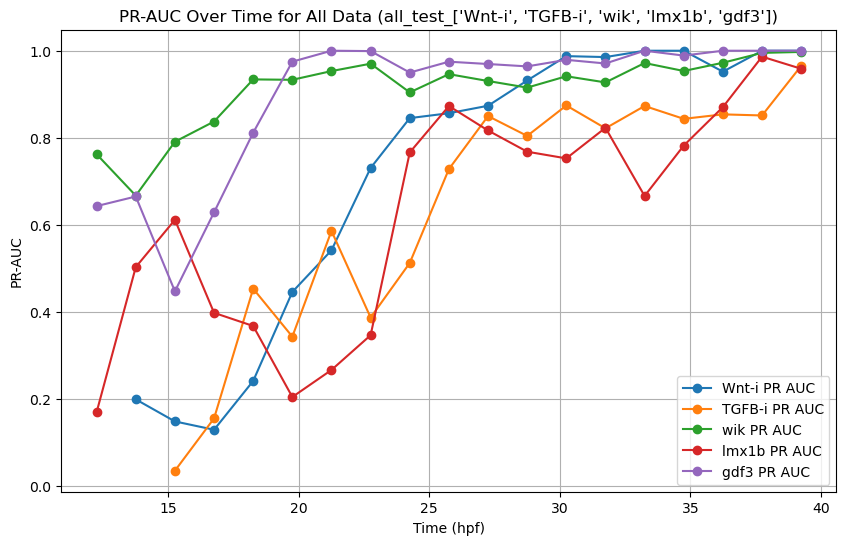

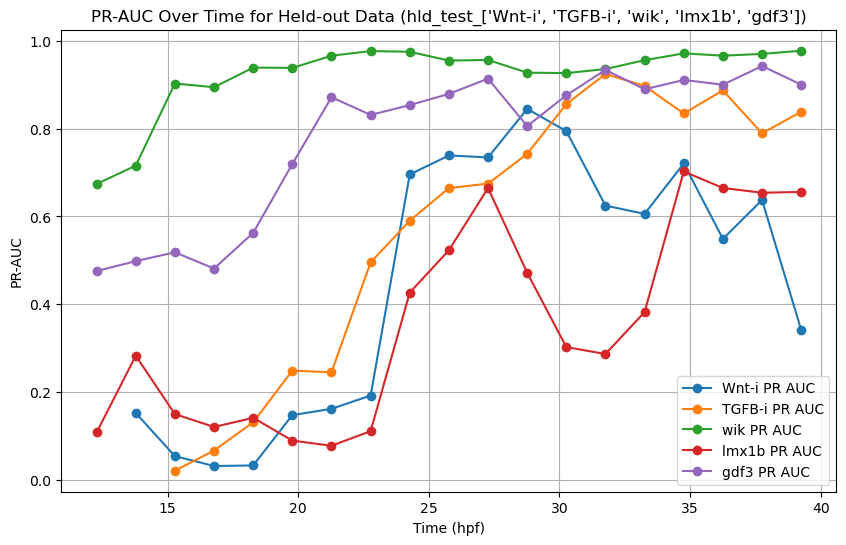

In [9]:
plot_pr_auc_over_time(results_dict_all, pert_comparisons,dataset_label=f'all_test_{pert_comparisons}' , title="PR-AUC Over Time for All Data")

plot_pr_auc_over_time(results_dict_hld, pert_comparisons, dataset_label= f'hld_test_{pert_comparisons}', title="PR-AUC Over Time for Held-out Data")


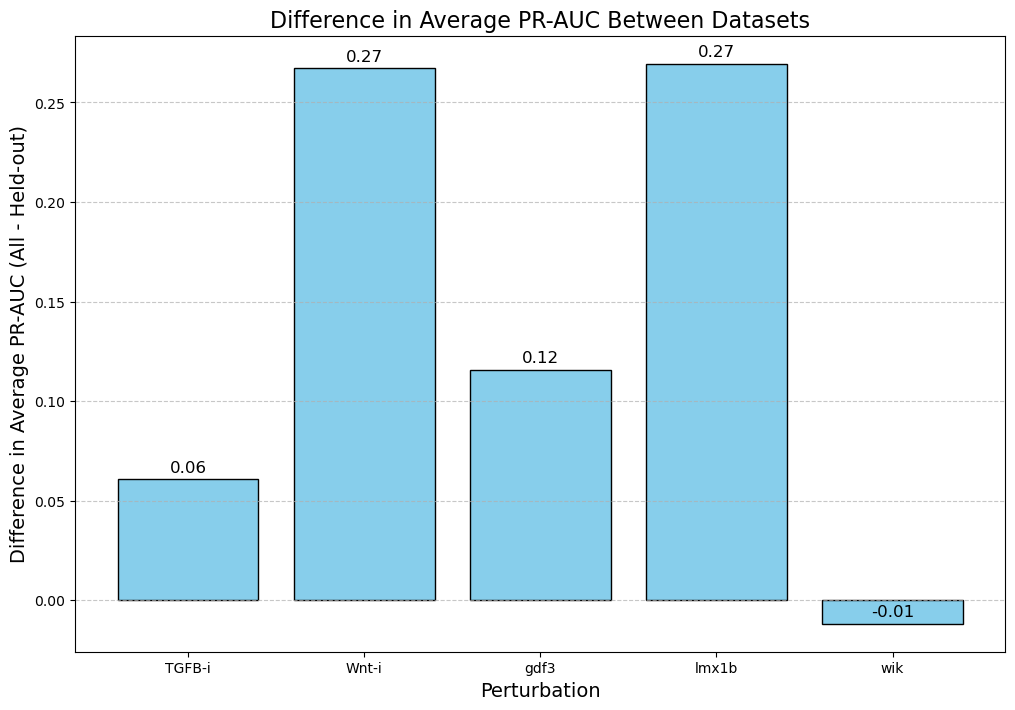

In [10]:
# --- Main Processing ---
# Step 1: Create per-bin PR-AUC dataframe
pr_auc_df = create_pr_auc_dataframe(results_dict_all, results_dict_hld, pert_comparisons)

# Step 2: Compute average PR-AUC and differences
avg_pr_auc_df = compute_average_pr_auc(pr_auc_df)

# Step 3: Plot the differences in average PR-AUC
plot_average_pr_auc_difference(avg_pr_auc_df)

# Step 4: Save dataframes as CSV files
# save_dataframes(pr_auc_df, avg_pr_auc_df)


## F1 Scores functions and outputs 

In [11]:
from sklearn.metrics import f1_score

def compute_f1_score_over_time_bins(data, cls, num_bins=20, max_hpf=40):
    """
    Compute F1 scores over time bins for a specific class.

    Parameters:
    - data (pd.DataFrame): DataFrame containing 'predicted_stage_hpf', 'y_true', and 'y_pred'.
    - num_bins (int): Number of time bins to divide the data into.
    - max_hpf (float or None): Maximum hpf value to include in the analysis. If None, no filtering is applied.

    Returns:
    - bin_centers (np.ndarray): The centers of the time bins.
    - f1_score_list (list): The F1 scores for each time bin.
    """
    # Filter data based on max_hpf
    if max_hpf is not None:
        data = data[data['predicted_stage_hpf'] <= max_hpf]

    # Check if data is empty after filtering
    if data.empty:
        print("No data available after filtering by max_hpf.")
        return np.array([]), []

    # Define time bins
    time_min = data['predicted_stage_hpf'].min()
    time_max = data['predicted_stage_hpf'].max()
    bins = np.linspace(time_min, time_max, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    f1_score_list = []

    # Compute F1 score for each time bin
    for i in range(num_bins):
        # Get the data in the current time bin
        bin_mask = (data['predicted_stage_hpf'] >= bins[i]) & (data['predicted_stage_hpf'] < bins[i + 1])
        bin_data = data[bin_mask]

        if not bin_data.empty:
            y_true  = bin_data['class_num'] == cls
            y_pred  = bin_data['y_pred']    == cls

            # Compute number of positive and negative samples
            num_positive = np.sum(y_true)
            num_negative = np.sum(~y_true)

            # Append NaN if either num_positive or num_negative is zero
            if num_positive == 0 or num_negative == 0:
                f1_score_list.append(np.nan)
            else:
                f1 = f1_score(y_true, y_pred)
                f1_score_list.append(f1)
        else:
            f1_score_list.append(np.nan)

    return bin_centers, f1_score_list

def f1_score_over_time_multiclass(y_test, y_pred_proba, test_df, perturbations, num_bins=20, max_hpf=40):
    """
    Compute F1 scores over time bins for the multiclass problem without plotting.

    Parameters:
    - y_test (np.ndarray): True class labels.
    - y_pred_proba (np.ndarray): Predicted probabilities from the classifier.
    - test_df (pd.DataFrame): Test DataFrame containing 'predicted_stage_hpf' and 'class_num'.
    - perturbations (list): List of class names corresponding to the classes.
    - num_bins (int): Number of time bins to divide the data into.
    - max_hpf (float or None): Maximum hpf value to include in the analysis. If None, no filtering is applied.

    Returns:
    - results_dict (dict): Dictionary containing bin centers and F1 score lists for each perturbation.
    """
    # Prepare the test results dataframe with predicted probabilities and the true class labels
    test_results_df = test_df[['predicted_stage_hpf', 'class_num']].copy()

    # Add predicted probabilities to the DataFrame for each class
    for i, pert in enumerate(perturbations):
        test_results_df[f'y_pred_proba_{pert}'] = y_pred_proba[:, i]

    # Add predicted class labels (argmax over predicted probabilities)
    y_pred = np.argmax(y_pred_proba, axis=1)
    test_results_df['y_pred'] = y_pred.astype(int)
    test_results_df['y_true'] = y_test.astype(int)

    # Dictionary to store results
    results_dict = {}

    # Compute F1 scores for each perturbation
    for i, pert in enumerate(perturbations):
        # Prepare data for this perturbation
        data = test_results_df[['predicted_stage_hpf', 'class_num', f'y_pred_proba_{pert}', 'y_true', 'y_pred']].copy()
        data.rename(columns={f'y_pred_proba_{pert}': 'y_pred_proba'}, inplace=True)

        # Compute F1 score over time bins
        bin_centers, f1_score_list = compute_f1_score_over_time_bins(
            data, cls=i, num_bins=num_bins, max_hpf=max_hpf)

        # Store results
        results_dict[pert] = {
            'bin_centers': bin_centers,
            'f1_score_list': f1_score_list
        }

    return results_dict

def plot_f1_score_over_time(results_dict, perturbations, dataset_label='', title="F1 Score Over Time for Perturbations", plot=True, save=False):
    """
    Plot F1 scores over time for the multiclass problem using the results from f1_score_over_time_multiclass.

    Parameters:
    - results_dict (dict): Dictionary containing bin centers and F1 score lists for each perturbation.
    - perturbations (list): List of perturbation names.
    - dataset_label (str): Label to differentiate datasets (e.g., 'all', 'hld'). Default is ''.
    - title (str): Title of the plot.
    - plot (bool): Whether to display the plot. Defaults to True.
    - save (bool): Whether to save the plot. Defaults to False.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))

    # Plot F1 score for each perturbation
    for pert in perturbations:
        bin_centers = results_dict[pert]['bin_centers']
        f1_score_list = results_dict[pert]['f1_score_list']
        plt.plot(bin_centers, f1_score_list, label=f'{pert} F1 Score', marker='o')

    plt.xlabel("Time (hpf)")
    plt.ylabel("F1 Score")
    plt.title(f"{title} ({dataset_label})" if dataset_label else title)
    plt.legend()
    plt.grid(True)

    # Save the F1 score plot if save=True
    if save:
        filename = f"f1_score_over_time_multiclass_{dataset_label}.png" if dataset_label else "f1_score_over_time_multiclass.png"
        f1_score_plot_path = os.path.join(results_path("multiclass_classification_test"), filename)
        plt.savefig(f1_score_plot_path)
        print("F1 score plot saved to:", f1_score_plot_path)

    # Display the plot if plot=True
    if plot:
        plt.show()

    # Close the plot to free memory
    plt.close()

def plot_f1_score_comparison(results_dict1, results_dict2, perturbation, labels, title, filename_suffix=''):
    """
    Plot F1 scores over time for a specific perturbation from two different results_dicts.

    Parameters:
    - results_dict1 (dict): First results dictionary.
    - results_dict2 (dict): Second results dictionary.
    - perturbation (str): The perturbation to plot.
    - labels (tuple): A tuple of labels for the two datasets (e.g., ('All Data', 'Held-out Data')).
    - title (str): Title of the plot.
    - filename_suffix (str): Suffix to differentiate the filename.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))

    # Dataset 1
    bin_centers1 = results_dict1[perturbation]['bin_centers']
    f1_score_list1 = results_dict1[perturbation]['f1_score_list']
    plt.plot(bin_centers1, f1_score_list1, labels=f'{labels[0]} - {perturbation}', marker='o')

    # Dataset 2
    bin_centers2 = results_dict2[perturbation]['bin_centers']
    f1_score_list2 = results_dict2[perturbation]['f1_score_list']
    plt.plot(bin_centers2, f1_score_list2, label=f'{labels[1]} - {perturbation}', marker='x')

    plt.xlabel("Time (hpf)")
    plt.ylabel("F1 Score")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Save the comparison plot
    filename = f"f1_score_comparison_{perturbation}_{filename_suffix}.png" if filename_suffix else f"f1_score_comparison_{perturbation}.png"
    f1_score_plot_path = os.path.join(results_path("multiclass_classification_test"), filename)
    plt.savefig(f1_score_plot_path)
    plt.close()

    print(f"Comparison plot saved to: {f1_score_plot_path}")

def create_f1_score_dataframe(results_dict_all, results_dict_hld, perturbations):
    """
    Create a dataframe containing per-bin F1 scores and their differences for each perturbation and each dataset.
    
    Parameters:
    - results_dict_all (dict): Results dictionary from 'all' dataset.
    - results_dict_hld (dict): Results dictionary from 'hld' dataset.
    - perturbations (list): List of perturbation names.
    
    Returns:
    - f1_score_df (pd.DataFrame): Dataframe containing per-bin F1 scores and differences.
    """
    data = []

    for pert in perturbations:
        # Get bin centers and F1 scores for both datasets
        bin_centers_all = results_dict_all[pert]['bin_centers']
        f1_score_all = results_dict_all[pert]['f1_score_list']
        
        bin_centers_hld = results_dict_hld[pert]['bin_centers']
        f1_score_hld = results_dict_hld[pert]['f1_score_list']

        # Round bin centers to the nearest integer
        bin_centers_all_rounded = np.round(bin_centers_all).astype(int)
        bin_centers_hld_rounded = np.round(bin_centers_hld).astype(int)

        # Ensure that the rounded bin centers match between datasets
        if not np.array_equal(bin_centers_all_rounded, bin_centers_hld_rounded):
            raise ValueError(f"Bin centers for perturbation '{pert}' do not match between datasets.")
        
        # For each bin, record the F1 scores and their difference
        for i in range(len(bin_centers_all)):
            difference = f1_score_all[i] - f1_score_hld[i]
            data.append({
                'Perturbation': pert,
                'bin': i + 1,  # Bins numbered from 1 to num_bins
                'bin_center': bin_centers_all_rounded[i],
                'F1_score_all': f1_score_all[i],
                'F1_score_hld': f1_score_hld[i],
                'F1_all_hld_diff': difference
            })

    # Create DataFrame
    f1_score_df = pd.DataFrame(data)
    
    return f1_score_df

def compute_average_f1_score(f1_score_df):
    """
    Compute the average F1 score across bins for each perturbation and dataset, and calculate the differences.
    
    Parameters:
    - f1_score_df (pd.DataFrame): Dataframe containing per-bin F1 scores.
    
    Returns:
    - avg_f1_score_df (pd.DataFrame): Dataframe containing average F1 scores and differences.
    """
    # Group by perturbation and compute mean F1 score, ignoring NaN values
    avg_f1_score = f1_score_df.groupby('Perturbation').agg({
        'F1_score_all': 'mean',
        'F1_score_hld': 'mean'
    }).reset_index()
    
    # Calculate the difference
    avg_f1_score['F1_all_hld_diff'] = avg_f1_score['F1_score_all'] - avg_f1_score['F1_score_hld']
    
    return avg_f1_score

def plot_average_f1_score_difference(avg_f1_score_df, plot=True, save=False):
    """
    Plot the differences in average F1 scores between the two datasets for each perturbation.
    
    Parameters:
    - avg_f1_score_df (pd.DataFrame): DataFrame containing 'perturbation' and 'difference' columns.
    - plot (bool): Whether to display the plot interactively. Defaults to True.
    - save (bool): Whether to save the plot to a file. Defaults to False.
    
    Returns:
    - None
    """
    plt.figure(figsize=(12, 8))
    perturbations = avg_f1_score_df['Perturbation']
    differences = avg_f1_score_df['F1_all_hld_diff']
    
    bars = plt.bar(perturbations, differences, color='skyblue', edgecolor='black')
    plt.xlabel('Perturbation', fontsize=14)
    plt.ylabel('Difference in Average F1 Score (All - Held-out)', fontsize=14)
    plt.title('Difference in Average F1 Score Between Datasets', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate bars with difference values
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            plt.annotate(f'{height:.2f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=12)
    
    # Save the plot if save=True
    if save:
        filename = "average_f1_score_difference.png"
        plot_path = os.path.join(results_path("multiclass_classification_test"), filename)
        plt.savefig(plot_path, bbox_inches='tight')
        print("Average F1 Score difference plot saved to:", plot_path)
    
    # Display the plot if plot=True
    if plot:
        plt.show()
    
    # Close the plot to free memory
    plt.close()


### Usage Example

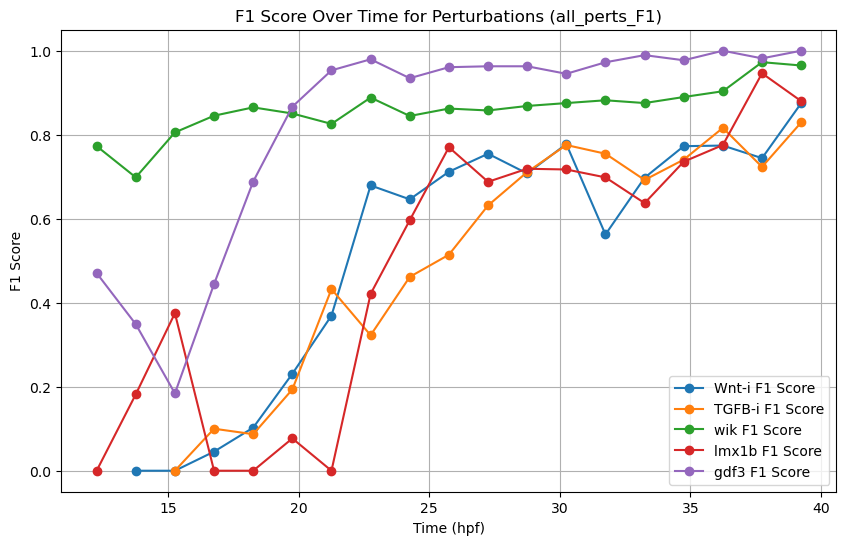

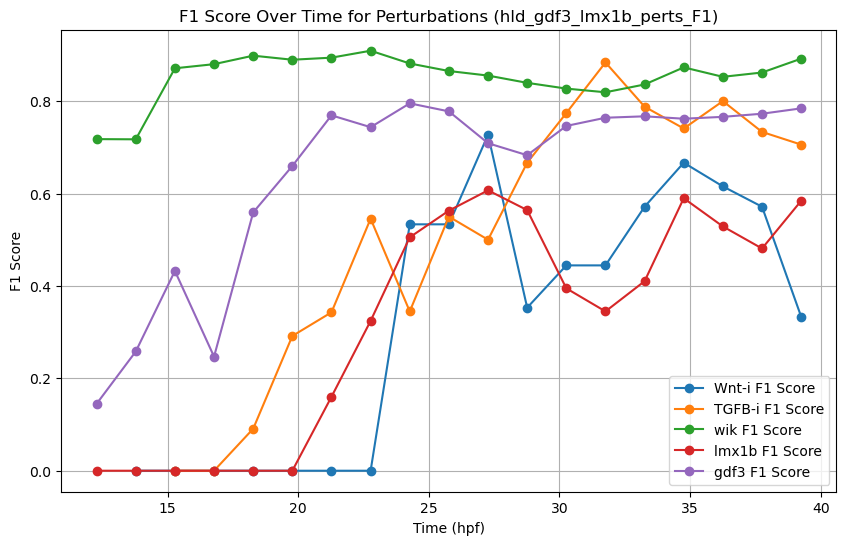

In [12]:
# Assuming you have y_test, y_pred, test_df, and perturbations defined

# Compute F1 scores over time for the multiclass problem

##all
results_dict_all = f1_score_over_time_multiclass(y_test_all, y_pred_proba_all, test_df_all, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'all_perts_F1'
plot_f1_score_over_time(results_dict_all, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")

#hld
results_dict_hld = f1_score_over_time_multiclass(y_test_hld, y_pred_proba_hld, test_df_hld, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'hld_gdf3_lmx1b_perts_F1'
plot_f1_score_over_time(results_dict_hld, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")


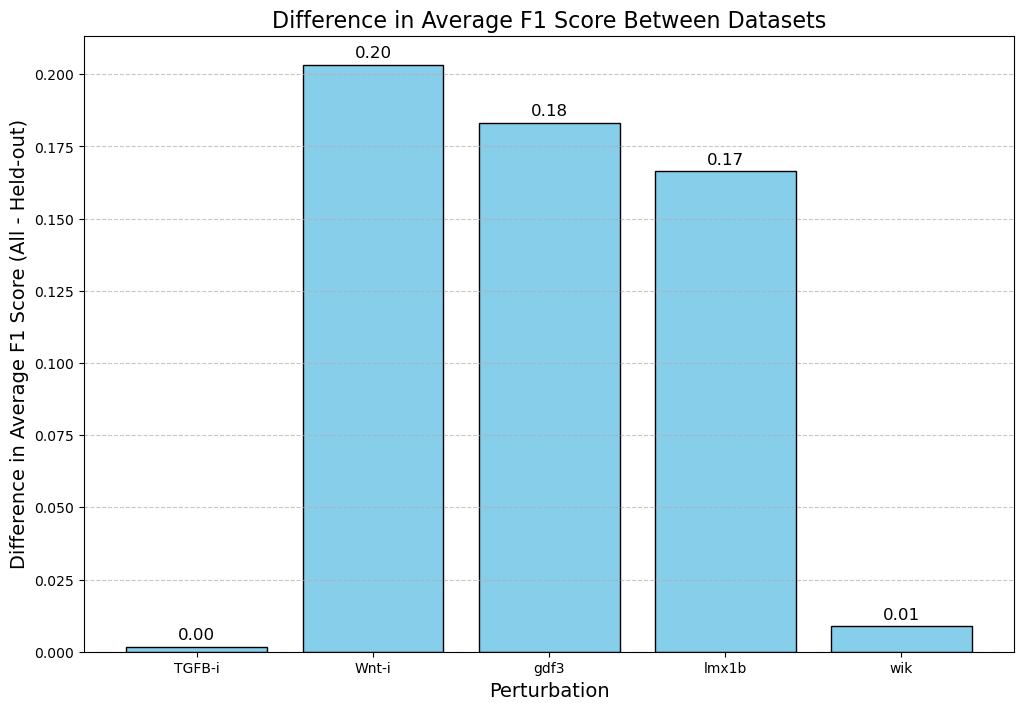

In [13]:
# --- Main Processing ---
# Step 1: Create per-bin F1 score dataframe
f1_score_df = create_f1_score_dataframe(results_dict_all, results_dict_hld, pert_comparisons)

# # Step 2: Compute average F1 scores and differences
avg_f1_score_df = compute_average_f1_score(f1_score_df)

# # Step 3: Plot the differences in average F1 scores
plot_average_f1_score_difference(avg_f1_score_df)


In [14]:
f1_score_df

,Perturbation,bin,bin_center,F1_score_all,F1_score_hld,F1_all_hld_diff
0,Wnt-i,1,11,NaN,NaN,NaN
1,Wnt-i,2,12,NaN,NaN,NaN
2,Wnt-i,3,14,0.000000,0.000000,0.000000
3,Wnt-i,4,15,0.000000,0.000000,0.000000
4,Wnt-i,5,17,0.045455,0.000000,0.045455
...,...,...,...,...,...,...
95,gdf3,16,33,0.989474,0.767123,0.222350
96,gdf3,17,35,0.977273,0.761905,0.215368
97,gdf3,18,36,1.000000,0.765957,0.234043
98,gdf3,19,38,0.981818,0.772727,0.209091


In [15]:
avg_f1_score_df

,Perturbation,F1_score_all,F1_score_hld,F1_all_hld_diff
0,TGFB-i,0.516842,0.515184,0.001657
1,Wnt-i,0.525097,0.321890,0.203208
2,gdf3,0.822291,0.638998,0.183293
3,lmx1b,0.485197,0.318796,0.166401
4,wik,0.860461,0.851603,0.008858


# Distance Measurements

In [16]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, cdist

# List of DataFrames and titles for processing
dataframes = [
    (df_all, 'Original Data'),
    (df_hld, 'No lmx1b gdf3')
]

random_state = 100

# List of perturbations to process
pert_comparisons

# Subsample fraction
subsample_fraction = 0.05  # Adjust as needed

# Functions to compute metrics
def compute_graph_metrics(z_mu_data):
    """
    Compute graph metrics for the given data.
    """
    k_neighbors = 10
    knn = NearestNeighbors(n_neighbors=min(k_neighbors, len(z_mu_data)))
    knn.fit(z_mu_data)
    knn_graph = knn.kneighbors_graph(z_mu_data, mode='connectivity')
    G = nx.Graph(knn_graph)

    metrics = {}
    if nx.is_connected(G):
        metrics['avg_path_length'] = nx.average_shortest_path_length(G)
    else:
        # Compute metrics on the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc).copy()
        metrics['avg_path_length'] = nx.average_shortest_path_length(subgraph)
    metrics['clustering_coeff'] = nx.average_clustering(G)
    return metrics

def compute_histogram(distances, bins=30):
    """
    Compute histogram counts and bin edges for the given distances.
    """
    counts, bin_edges = np.histogram(distances, bins=bins, density=True)
    return counts, bin_edges

def compute_kl_divergence(ref_counts, counts):
    """
    Compute KL divergence between the reference histogram counts and current counts.
    """
    epsilon = 1e-10  # To prevent division by zero
    P = ref_counts + epsilon
    Q = counts + epsilon
    P /= np.sum(P)
    Q /= np.sum(Q)
    KL_div = np.sum(P * np.log(P / Q))
    return KL_div

def compute_metrics_for_dataframes(dataframes, comparisons, subsample_fraction=0.05, random_state=100):
    """
    Compute metrics for given dataframes and comparisons.

    Parameters:
    - dataframes: List of tuples (DataFrame, title)
    - comparisons: List of perturbations to process
    - subsample_fraction: Fraction of data to subsample
    - random_state: Seed for reproducibility

    Returns:
    - metrics_intra_df: DataFrame containing intra-perturbation metrics
    - metrics_inter_df: DataFrame containing inter-perturbation metrics
    """
    # Prepare dictionaries to store results
    reference_histograms = {'intra': {}, 'inter': {}}
    metrics_intra_list = []
    metrics_inter_list = []

    # Loop over intra- and inter-perturbation distances
    for distance_type in ['intra', 'inter']:
        # Loop over each DataFrame and its title
        for df_idx, (df, df_title) in enumerate(dataframes):
            # Sample data for all perturbations
            subsampled_data = {}
            for perturbation in comparisons:
                df_pert = df[df['master_perturbation'] == perturbation].copy()
                if df_pert.empty:
                    # Skip perturbations not present in the DataFrame
                    continue
                embryo_ids = df_pert['embryo_id'].unique()

                # Initialize a list to store samples from each embryo_id
                samples_per_embryo = []

                for embryo_id in embryo_ids:
                    df_embryo = df_pert[df_pert['embryo_id'] == embryo_id]
                    # Ensure at least one data point is sampled from each embryo_id
                    n_samples = max(int(len(df_embryo) * subsample_fraction), 1)
                    df_embryo_sampled = df_embryo.sample(n=n_samples, random_state=random_state)
                    samples_per_embryo.append(df_embryo_sampled)

                # Combine samples from all embryo_ids for this perturbation
                df_pert_sampled = pd.concat(samples_per_embryo, ignore_index=True)
                subsampled_data[perturbation] = df_pert_sampled

            # Combine all subsampled data into a global dataset
            df_sampled = pd.concat(subsampled_data.values(), ignore_index=True)
            z_mu_data_sampled = df_sampled[z_mu_biological_columns].values

            # Compute global mean and std for z-scoring
            full_distances_sampled = pdist(z_mu_data_sampled, metric='euclidean')
            mean_dist = np.mean(full_distances_sampled)
            std_dist = np.std(full_distances_sampled)

            # Loop over the perturbations to compare
            for perturbation in comparisons:
                if perturbation not in subsampled_data:
                    continue  # Skip if perturbation data is missing

                df_pert_sampled = subsampled_data[perturbation]
                z_mu_data_pert = df_pert_sampled[z_mu_biological_columns].values

                # Ensure there are enough points
                if len(z_mu_data_pert) < 2:
                    continue

                if distance_type == 'intra':
                    # Intra-perturbation distances
                    distances = pdist(z_mu_data_pert, metric='euclidean')
                    z_mu_data_for_metrics = z_mu_data_pert  # For graph metrics
                else:
                    # Inter-perturbation distances
                    # Sample points from other perturbations
                    other_perturbations = [p for p in comparisons if p != perturbation and p in subsampled_data]
                    if not other_perturbations:
                        continue
                    df_other = pd.concat([subsampled_data[p] for p in other_perturbations], ignore_index=True)
                    z_mu_data_other = df_other[z_mu_biological_columns].values

                    # Ensure same number of points
                    n_samples = len(z_mu_data_pert)
                    if len(z_mu_data_other) > n_samples:
                        indices = np.random.choice(len(z_mu_data_other), n_samples, replace=False)
                        z_mu_data_other = z_mu_data_other[indices]
                    elif len(z_mu_data_other) < 2:
                        continue

                    # Compute distances between z_mu_data_pert and z_mu_data_other
                    distances = cdist(z_mu_data_pert, z_mu_data_other, metric='euclidean').flatten()
                    # For graph metrics, combine both datasets
                    z_mu_data_for_metrics = np.vstack((z_mu_data_pert, z_mu_data_other))

                # Z-score distances
                distances_z = (distances - mean_dist) / std_dist

                # Compute metrics
                metrics = compute_graph_metrics(z_mu_data_for_metrics)

                # Compute histogram and KL divergence
                # Use the same bin edges across all datasets for consistency
                if df_title == 'Original Data':
                    # Compute histogram counts and bin edges for the reference dataset
                    counts, bin_edges = compute_histogram(distances_z, bins=30)
                    # Store the reference histogram
                    reference_histograms[distance_type][perturbation] = {'counts': counts, 'bin_edges': bin_edges}
                    KL_div = 0.0  # KL divergence is zero for the reference
                else:
                    # Use the reference histogram's bin edges
                    ref_hist = reference_histograms[distance_type].get(perturbation)
                    if ref_hist is None:
                        continue

                    bin_edges = ref_hist['bin_edges']

                    # Compute histogram counts using the same bin edges
                    counts, _ = np.histogram(distances_z, bins=bin_edges, density=True)

                    # Compute KL divergence
                    KL_div = compute_kl_divergence(ref_hist['counts'], counts)

                # Store metrics in the appropriate list
                metrics_entry = {
                    'DataFrame': df_title,
                    'Perturbation': perturbation,
                    'Avg_Path_Length': metrics['avg_path_length'],
                    'Clustering_Coeff': metrics['clustering_coeff'],
                    'KL_Divergence': KL_div
                }

                if distance_type == 'intra':
                    metrics_intra_list.append(metrics_entry)
                else:
                    metrics_inter_list.append(metrics_entry)

    # Convert the lists of metrics to DataFrames
    metrics_intra_df = pd.DataFrame(metrics_intra_list)
    metrics_inter_df = pd.DataFrame(metrics_inter_list)

    return metrics_intra_df, metrics_inter_df

def compute_differences(metrics_intra_df, metrics_inter_df, reference_title, comparison_title):
    """
    Compute the differences between the metrics of the comparison DataFrame and the reference DataFrame.

    Parameters:
    - metrics_intra_df: DataFrame containing intra-perturbation metrics
    - metrics_inter_df: DataFrame containing inter-perturbation metrics
    - reference_title: Title of the reference DataFrame (e.g., 'Original Data')
    - comparison_title: Title of the comparison DataFrame (e.g., 'No lmx1b gdf3')

    Returns:
    - diff_intra: DataFrame containing differences in intra-perturbation metrics
    - diff_inter: DataFrame containing differences in inter-perturbation metrics
    """
    # Intra-Perturbation Differences
    metrics_intra_reference = metrics_intra_df[metrics_intra_df['DataFrame'] == reference_title]
    metrics_intra_comparison = metrics_intra_df[metrics_intra_df['DataFrame'] == comparison_title]

    # Merge on 'Perturbation'
    merged_intra = pd.merge(
        metrics_intra_reference,
        metrics_intra_comparison,
        on='Perturbation',
        suffixes=('_reference', '_comparison')
    )

    # Compute differences
    merged_intra['Avg_Path_Length_Diff'] = merged_intra['Avg_Path_Length_comparison'] - merged_intra['Avg_Path_Length_reference']
    merged_intra['Clustering_Coeff_Diff'] = merged_intra['Clustering_Coeff_comparison'] - merged_intra['Clustering_Coeff_reference']
    merged_intra['KL_Divergence_Diff'] = merged_intra['KL_Divergence_comparison'] - merged_intra['KL_Divergence_reference']

    # Select relevant columns
    diff_intra = merged_intra[['Perturbation', 'Avg_Path_Length_Diff', 'Clustering_Coeff_Diff', 'KL_Divergence_Diff']]

    # Inter-Perturbation Differences
    metrics_inter_reference = metrics_inter_df[metrics_inter_df['DataFrame'] == reference_title]
    metrics_inter_comparison = metrics_inter_df[metrics_inter_df['DataFrame'] == comparison_title]

    # Merge on 'Perturbation'
    merged_inter = pd.merge(
        metrics_inter_reference,
        metrics_inter_comparison,
        on='Perturbation',
        suffixes=('_reference', '_comparison')
    )

    # Compute differences
    merged_inter['Avg_Path_Length_Diff'] = merged_inter['Avg_Path_Length_comparison'] - merged_inter['Avg_Path_Length_reference']
    merged_inter['Clustering_Coeff_Diff'] = merged_inter['Clustering_Coeff_comparison'] - merged_inter['Clustering_Coeff_reference']
    merged_inter['KL_Divergence_Diff'] = merged_inter['KL_Divergence_comparison'] - merged_inter['KL_Divergence_reference']

    # Select relevant columns
    diff_inter = merged_inter[['Perturbation', 'Avg_Path_Length_Diff', 'Clustering_Coeff_Diff', 'KL_Divergence_Diff']]

    return diff_intra, diff_inter

def plot_differences_together(diff_df, distance_type, plot=True, save=False):
    """
    Plot differences in metrics together in a grid for a given distance type (Intra or Inter).
    
    Parameters:
    - diff_df (pd.DataFrame): DataFrame containing the differences in metrics (diff_intra or diff_inter).
    - distance_type (str): String indicating the type ('Intra' or 'Inter').
    - plot (bool): Whether to display the plots interactively. Defaults to True.
    - save (bool): Whether to save the plots to files. Defaults to False.
    
    Returns:
    - None
    """
    sns.set(style="whitegrid")
    
    # Metrics to plot
    metric_names = ['Avg_Path_Length_Diff', 'Clustering_Coeff_Diff', 'KL_Divergence_Diff']
    metric_labels = {
        'Avg_Path_Length_Diff': 'Average Path Length',
        'Clustering_Coeff_Diff': 'Clustering Coefficient',
        'KL_Divergence_Diff': 'KL Divergence'
    }
    
    num_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(6*num_metrics, 6))
    
    for ax, metric in zip(axes, metric_names):
        # Extract relevant data
        data = diff_df[['Perturbation', metric]].copy()
        data = data.rename(columns={metric: 'Difference'})
        
        # Create the bar plot with a single color
        sns.barplot(
            data=data,
            x='Perturbation',
            y='Difference',
            color='skyblue',
            edgecolor='black',
            ax=ax
        )
        
        ax.set_xlabel('Perturbation', fontsize=14)
        ax.set_ylabel('Difference', fontsize=14)
        ax.set_title(f"{metric_labels[metric]}", fontsize=16)  # Condensed title
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Annotate bars with difference values
        for index, row in data.iterrows():
            ax.text(
                index, 
                row['Difference'], 
                f"{row['Difference']:.2f}", 
                color='black', 
                ha="center", 
                va='bottom', 
                fontsize=12
            )
    
    # Add a global title
    fig.suptitle(f'Differences in Metrics Between Datasets ({distance_type}-Perturbation)', fontsize=18)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
    
    # Save the plot if save=True
    if save:
        filename = f"metrics_difference_{distance_type.lower()}.png"
        plot_path = os.path.join(results_path("multiclass_classification_test"), filename)
        plt.savefig(plot_path, bbox_inches='tight')
        print(f"Metrics difference plot saved to:", plot_path)
    
    # Display the plot if plot=True
    if plot:
        plt.show()
    
    # Close the plot to free memory
    plt.close()


### Usage Example

In [17]:
# Compute the metrics
metrics_intra_df, metrics_inter_df = compute_metrics_for_dataframes(
    dataframes=dataframes,
    comparisons=pert_comparisons,
    subsample_fraction=subsample_fraction,
    random_state=random_state
)

# Compute the differences
diff_intra, diff_inter = compute_differences(
    metrics_intra_df,
    metrics_inter_df,
    reference_title='Original Data',
    comparison_title='No lmx1b gdf3'
)


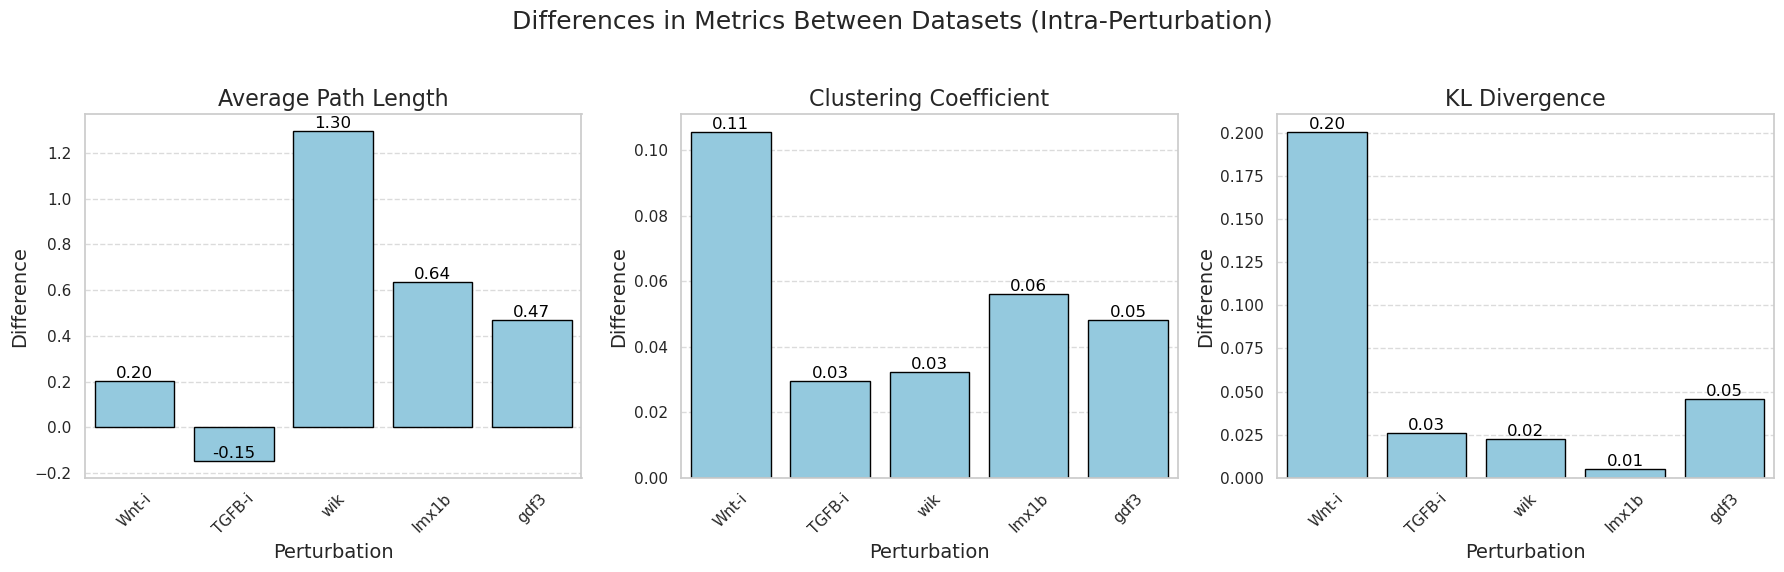

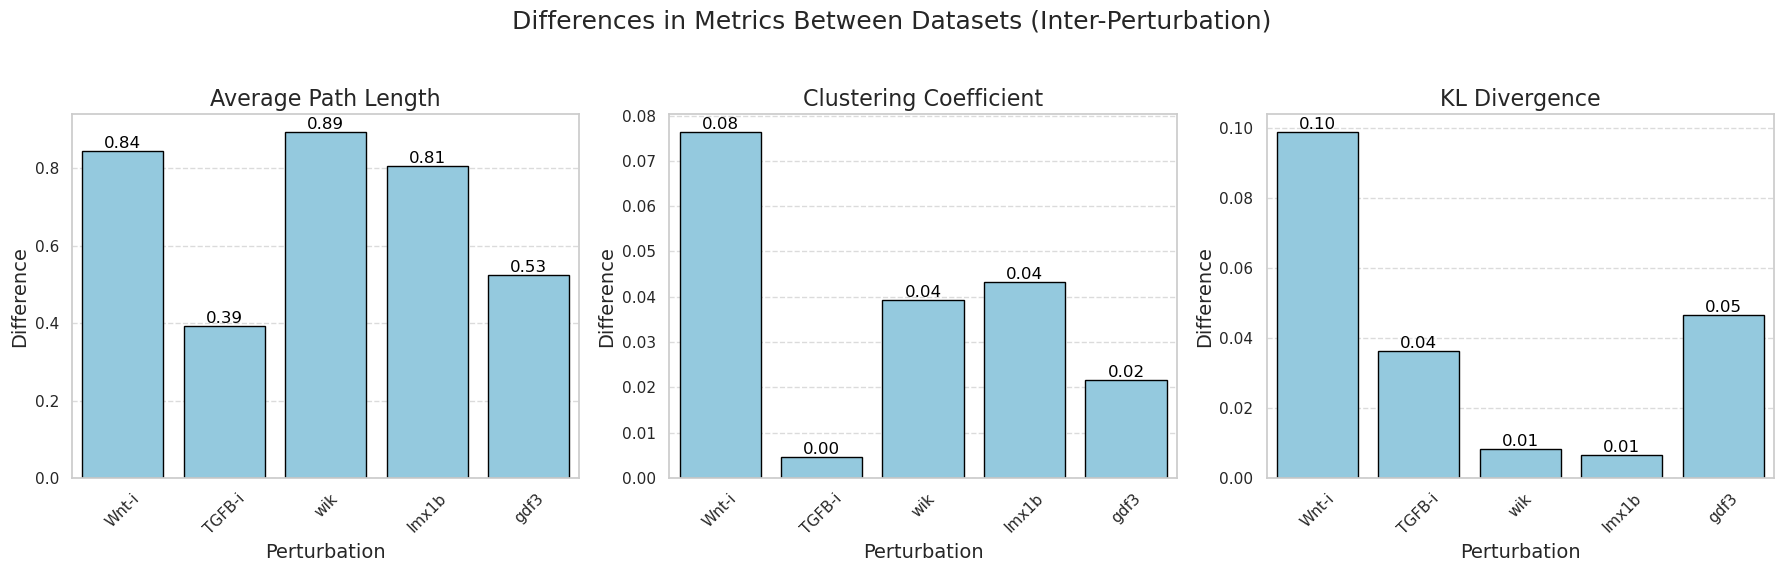

In [18]:
# Plot differences together for intra-perturbation
plot_differences_together(diff_intra, 'Intra')

# Plot differences together for inter-perturbation
plot_differences_together(diff_inter, 'Inter')

In [19]:
# Add suffix "_intra" to columns in metrics_intra_df if they don't already have it
metrics_intra_df.columns = [
    f"{col}_intra" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_intra") else col
    for col in metrics_intra_df.columns
]

# Add suffix "_inter" to columns in metrics_inter_df if they don't already have it
metrics_inter_df.columns = [
    f"{col}_inter" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_inter") else col
    for col in metrics_inter_df.columns
]


adding suffix to distinguish intra, and inter

In [20]:
diff_intra.columns = [
    f"{col}_intra" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_intra") else col
    for col in diff_intra.columns
]

# Add suffix "_inter" to columns in metrics_inter_df if they don't already have it
diff_inter.columns = [
    f"{col}_inter" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_inter") else col
    for col in diff_inter.columns
]


In [21]:
diff_inter

,Perturbation,Avg_Path_Length_Diff_inter,Clustering_Coeff_Diff_inter,KL_Divergence_Diff_inter
0,Wnt-i,0.844171,0.076450,0.098983
1,TGFB-i,0.394050,0.004687,0.036318
2,wik,0.894941,0.039324,0.008357
3,lmx1b,0.806159,0.043214,0.006708
4,gdf3,0.525272,0.021702,0.046597


# KNN analysis


In [22]:
# Set number of neighbors (k) and subsample fraction
k_neighbors = 20
subsample_fraction = 0.1  # Adjust as needed

# List of DataFrames and titles for comparison
dataframes = [
    (df_hld, 'No lmx1b gdf3')
]

# Function to randomly subsample
def random_subsample(df, fraction, random_state=42):
    return df.sample(frac=fraction, random_state=random_state).reset_index(drop=True)

# Function to compute Jaccard similarities and return separate DataFrames
def compute_jaccard_similarities(orig_df, dataframes, comparisons, z_mu_biological_columns, k_neighbors=20, subsample_fraction=0.1):
    # Initialize lists to store results
    jaccard_results_global = []
    jaccard_results_inter = []
    jaccard_results_intra = []
    
    # Subsample original DataFrame once
    orig_subsampled = random_subsample(orig_df, subsample_fraction)
    
    # Fit NearestNeighbors model on original data (Global Structure)
    knn_orig = NearestNeighbors(n_neighbors=100)  # Use a large number to ensure enough neighbors after masking
    knn_orig.fit(orig_subsampled[z_mu_biological_columns].values)
    
    # Loop over each DataFrame in dataframes
    for df, df_label in dataframes:
        print(f"Processing DataFrame: {df_label}")
        
        # Subsample comparison DataFrame
        comp_subsampled = random_subsample(df, subsample_fraction)
        
        # Fit NearestNeighbors model on comparison data (Global Structure)
        knn_comp = NearestNeighbors(n_neighbors=100)  # Use a large number to ensure enough neighbors after masking
        knn_comp.fit(comp_subsampled[z_mu_biological_columns].values)
        
        # Loop over each perturbation
        for perturbation in comparisons:
            print(f"  Processing perturbation: {perturbation}")
            
            # Get subset of data for the current perturbation
            orig_subset = orig_subsampled[orig_subsampled['master_perturbation'] == perturbation]
            comp_subset = comp_subsampled[comp_subsampled['master_perturbation'] == perturbation]
            
            if orig_subset.empty or comp_subset.empty:
                print(f"    No data for perturbation {perturbation}")
                continue
            
            # Identify common snip_ids in both subsets
            common_snip_ids = set(orig_subset['snip_id']).intersection(set(comp_subset['snip_id']))
            if not common_snip_ids:
                print(f"    No common snip_ids for perturbation {perturbation}")
                continue
            
            # Initialize lists to store the similarity scores
            jaccard_similarities_all = []
            jaccard_similarities_inter = []
            jaccard_similarities_intra = []
            
            # Loop over the common snip_ids to compare nearest neighbors
            for snip_id in common_snip_ids:
                # Get the data points for this snip_id
                point_orig = orig_subset[orig_subset['snip_id'] == snip_id][z_mu_biological_columns].values
                point_comp = comp_subset[comp_subset['snip_id'] == snip_id][z_mu_biological_columns].values
                
                if point_orig.size == 0 or point_comp.size == 0:
                    continue  # Skip if no data for this snip_id
                
                # -- Global Structure --
                neighbors_orig_all = knn_orig.kneighbors(point_orig, return_distance=False)[0]
                neighbors_comp_all = knn_comp.kneighbors(point_comp, return_distance=False)[0]
                
                orig_neighbors_snip_ids_all = orig_subsampled.iloc[neighbors_orig_all]['snip_id'].values
                comp_neighbors_snip_ids_all = comp_subsampled.iloc[neighbors_comp_all]['snip_id'].values
                
                # Take the first k_neighbors
                orig_neighbors_snip_ids_all = orig_neighbors_snip_ids_all[:k_neighbors]
                comp_neighbors_snip_ids_all = comp_neighbors_snip_ids_all[:k_neighbors]
                
                # Calculate Jaccard similarity using the union of neighbor sets
                intersection_all = set(orig_neighbors_snip_ids_all).intersection(set(comp_neighbors_snip_ids_all))
                union_all = set(orig_neighbors_snip_ids_all).union(set(comp_neighbors_snip_ids_all))
                jaccard_similarity_all = len(intersection_all) / len(union_all)
                jaccard_similarities_all.append(jaccard_similarity_all)
                
                # -- Inter-Class Structure (exclude same perturbation) --
                # Filter neighbors to exclude same perturbation
                orig_neighbors_inter = orig_subsampled.iloc[neighbors_orig_all]
                comp_neighbors_inter = comp_subsampled.iloc[neighbors_comp_all]
                
                orig_neighbors_snip_ids_inter = orig_neighbors_inter[orig_neighbors_inter['master_perturbation'] != perturbation]['snip_id'].values
                comp_neighbors_snip_ids_inter = comp_neighbors_inter[comp_neighbors_inter['master_perturbation'] != perturbation]['snip_id'].values
                
                # Ensure we have enough neighbors
                orig_neighbors_snip_ids_inter = orig_neighbors_snip_ids_inter[:k_neighbors]
                comp_neighbors_snip_ids_inter = comp_neighbors_snip_ids_inter[:k_neighbors]
                
                if len(orig_neighbors_snip_ids_inter) > 0 and len(comp_neighbors_snip_ids_inter) > 0:
                    intersection_inter = set(orig_neighbors_snip_ids_inter).intersection(set(comp_neighbors_snip_ids_inter))
                    union_inter = set(orig_neighbors_snip_ids_inter).union(set(comp_neighbors_snip_ids_inter))
                    jaccard_similarity_inter = len(intersection_inter) / len(union_inter)
                    jaccard_similarities_inter.append(jaccard_similarity_inter)
                
                # -- Intra-Class Structure (only same perturbation) --
                # Filter neighbors to include only same perturbation
                orig_neighbors_intra = orig_subsampled.iloc[neighbors_orig_all]
                comp_neighbors_intra = comp_subsampled.iloc[neighbors_comp_all]
                
                orig_neighbors_snip_ids_intra = orig_neighbors_intra[orig_neighbors_intra['master_perturbation'] == perturbation]['snip_id'].values
                comp_neighbors_snip_ids_intra = comp_neighbors_intra[comp_neighbors_intra['master_perturbation'] == perturbation]['snip_id'].values
                
                # Ensure we have enough neighbors
                orig_neighbors_snip_ids_intra = orig_neighbors_snip_ids_intra[:k_neighbors]
                comp_neighbors_snip_ids_intra = comp_neighbors_snip_ids_intra[:k_neighbors]
                
                if len(orig_neighbors_snip_ids_intra) > 0 and len(comp_neighbors_snip_ids_intra) > 0:
                    intersection_intra = set(orig_neighbors_snip_ids_intra).intersection(set(comp_neighbors_snip_ids_intra))
                    union_intra = set(orig_neighbors_snip_ids_intra).union(set(comp_neighbors_snip_ids_intra))
                    jaccard_similarity_intra = len(intersection_intra) / len(union_intra)
                    jaccard_similarities_intra.append(jaccard_similarity_intra)
            
            # Store the average Jaccard similarities in the respective results lists
            if jaccard_similarities_all:
                avg_similarity_all = np.mean(jaccard_similarities_all)
                jaccard_results_global.append({
                    'DataFrame': df_label,
                    'Perturbation': perturbation,
                    'Jaccard Similarity': avg_similarity_all
                })
            if jaccard_similarities_inter:
                avg_similarity_inter = np.mean(jaccard_similarities_inter)
                jaccard_results_inter.append({
                    'DataFrame': df_label,
                    'Perturbation': perturbation,
                    'Jaccard Similarity': avg_similarity_inter
                })
            if jaccard_similarities_intra:
                avg_similarity_intra = np.mean(jaccard_similarities_intra)
                jaccard_results_intra.append({
                    'DataFrame': df_label,
                    'Perturbation': perturbation,
                    'Jaccard Similarity': avg_similarity_intra
                })
    
    # Convert results to DataFrames
    results_df_global = pd.DataFrame(jaccard_results_global)
    results_df_inter = pd.DataFrame(jaccard_results_inter)
    results_df_intra = pd.DataFrame(jaccard_results_intra)
    
    return results_df_global, results_df_inter, results_df_intra

# Function to plot the results
def plot_jaccard_results(results_df_global, results_df_inter, results_df_intra):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Plotting the bar charts
    # Set the seaborn style
    sns.set(style="whitegrid")
    
    # Create three subplots that share the same y-axis
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
    
    # Define the order of the datasets for consistent coloring
    dataset_order = results_df_global['DataFrame'].unique()
    
    # Create a color palette
    palette = sns.color_palette('tab10', n_colors=len(dataset_order))
    color_dict = dict(zip(dataset_order, palette))
    
    # Plot for 'Global Structure'
    sns.barplot(
        data=results_df_global,
        x='Perturbation',
        y='Jaccard Similarity',
        hue='DataFrame',
        hue_order=dataset_order,
        ax=axes[0],
        ci=None,
        palette=color_dict
    )
    axes[0].set_title('Point-Similarity; Global Structure')
    axes[0].set_xlabel('Perturbations')
    axes[0].set_ylabel('Average Jaccard Similarity')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    
    # Remove legend from the first plot if it exists
    legend = axes[0].get_legend()
    if legend is not None:
        legend.remove()
    
    # Plot for 'Inter-Class Structure'
    sns.barplot(
        data=results_df_inter,
        x='Perturbation',
        y='Jaccard Similarity',
        hue='DataFrame',
        hue_order=dataset_order,
        ax=axes[1],
        ci=None,
        palette=color_dict
    )
    axes[1].set_title('Point-Similarity; Inter-Class Structure')
    axes[1].set_xlabel('Perturbations')
    axes[1].set_ylabel('')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    
    # Remove legend from the second plot if it exists
    legend = axes[1].get_legend()
    if legend is not None:
        legend.remove()
    
    # Plot for 'Intra-Class Structure'
    sns.barplot(
        data=results_df_intra,
        x='Perturbation',
        y='Jaccard Similarity',
        hue='DataFrame',
        hue_order=dataset_order,
        ax=axes[2],
        ci=None,
        palette=color_dict
    )
    axes[2].set_title('Point-Similarity; Intra-Class Structure')
    axes[2].set_xlabel('Perturbations')
    axes[2].set_ylabel('')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
    
    # Remove legend from the third plot if it exists
    legend = axes[2].get_legend()
    if legend is not None:
        legend.remove()
    
    # Add a single legend for the entire figure
    handles, labels = axes[2].get_legend_handles_labels()
    fig.legend(handles, labels, title='Dataset', loc='upper right')
    
    # Adjust layout to reduce space between legend and plots
    plt.tight_layout()
    
    # Adjust the space to accommodate the legend
    plt.subplots_adjust(right=0.85)
    
    plt.show()



### Usage example



In [23]:

# Usage example:

# Compute the Jaccard similarities and get the separate results DataFrames
results_df_global, results_df_inter, results_df_intra = compute_jaccard_similarities(
    orig_df=df_all,
    dataframes=dataframes,
    comparisons=pert_comparisons,
    z_mu_biological_columns=z_mu_biological_columns,
    k_neighbors=k_neighbors,
    subsample_fraction=subsample_fraction
)

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: Wnt-i
  Processing perturbation: TGFB-i
  Processing perturbation: wik
  Processing perturbation: lmx1b
  Processing perturbation: gdf3


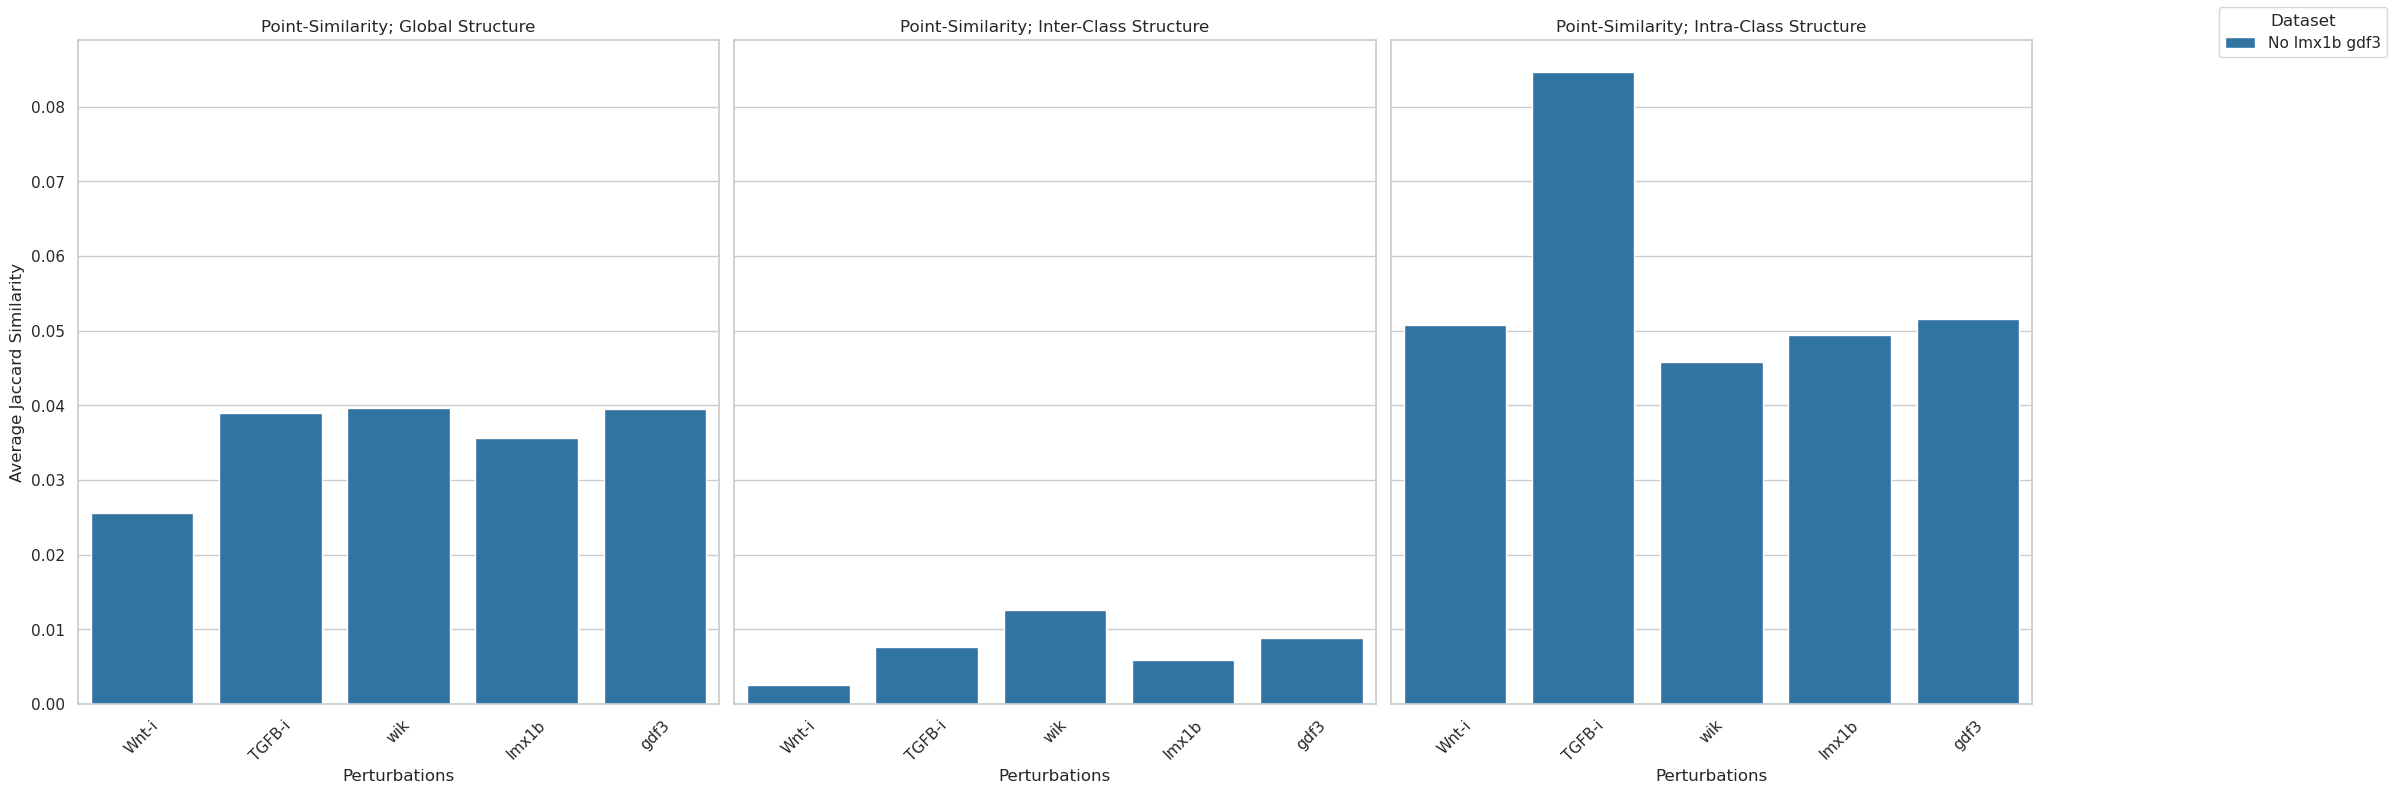

In [24]:
# Plot the results
plot_jaccard_results(results_df_global, results_df_inter, results_df_intra)

adding suffix to distinguish global, intra, and inter

In [25]:
# Add suffix "_inter" to columns in metrics_inter_df if they don't already have it
results_df_global.columns = [
    f"{col}_global" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_global") else col
    for col in results_df_global.columns
]

results_df_intra.columns = [
    f"{col}_intra" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_intra") else col
    for col in results_df_intra.columns
]

# Add suffix "_inter" to columns in metrics_inter_df if they don't already have it
results_df_inter.columns = [
    f"{col}_inter" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_inter") else col
    for col in results_df_inter.columns
]


# Combining and Saving Performance Metrics

here we save all of the key metrics, they can all be lined up by the "Perturbations" columns

In [26]:
# List of dataframes to merge
dfs_to_merge = [avg_f1_score_df, diff_intra, diff_inter, results_df_global, results_df_intra, results_df_inter]

# Set 'Perturbation' as the index and drop 'DataFrame' columns
dfs_to_merge = [df.set_index('Perturbation').drop(columns='DataFrame', errors='ignore') for df in dfs_to_merge]

# Merge all dataframes on the 'Perturbation' index
core_performance_metrics = pd.concat(dfs_to_merge, axis=1)

# Reset index if needed
core_performance_metrics.reset_index(inplace=True)

core_performance_metrics

,Perturbation,F1_score_all,F1_score_hld,F1_all_hld_diff,Avg_Path_Length_Diff_intra,Clustering_Coeff_Diff_intra,KL_Divergence_Diff_intra,Avg_Path_Length_Diff_inter,Clustering_Coeff_Diff_inter,KL_Divergence_Diff_inter,Jaccard Similarity_global,Jaccard Similarity_intra,Jaccard Similarity_inter
0,TGFB-i,0.516842,0.515184,0.001657,-0.149341,0.029742,0.026156,0.394050,0.004687,0.036318,0.038911,0.084647,0.007597
1,Wnt-i,0.525097,0.321890,0.203208,0.203931,0.105693,0.200498,0.844171,0.076450,0.098983,0.025641,0.050705,0.002564
2,gdf3,0.822291,0.638998,0.183293,0.469018,0.048354,0.045486,0.525272,0.021702,0.046597,0.039573,0.051501,0.008905
3,lmx1b,0.485197,0.318796,0.166401,0.637121,0.056235,0.005495,0.806159,0.043214,0.006708,0.035662,0.049382,0.005872
4,wik,0.860461,0.851603,0.008858,1.296322,0.032430,0.022779,0.894941,0.039324,0.008357,0.039617,0.045751,0.012644


this has the time "bin_centers" so that one can calculate scores over time if ther wish

In [27]:
f1_score_df

,Perturbation,bin,bin_center,F1_score_all,F1_score_hld,F1_all_hld_diff
0,Wnt-i,1,11,NaN,NaN,NaN
1,Wnt-i,2,12,NaN,NaN,NaN
2,Wnt-i,3,14,0.000000,0.000000,0.000000
3,Wnt-i,4,15,0.000000,0.000000,0.000000
4,Wnt-i,5,17,0.045455,0.000000,0.045455
...,...,...,...,...,...,...
95,gdf3,16,33,0.989474,0.767123,0.222350
96,gdf3,17,35,0.977273,0.761905,0.215368
97,gdf3,18,36,1.000000,0.765957,0.234043
98,gdf3,19,38,0.981818,0.772727,0.209091


this has the raw distance metric values, not the differences.

In [28]:
# Drop the 'DataFrame' and 'Perturbation' columns from metrics_inter_df
metrics_inter_df_dropped = metrics_inter_df.drop(columns=['DataFrame', 'Perturbation'])

# Append 'DataFrame' and 'Perturbation' columns from metrics_intra_df to metrics_inter_df_dropped
distance_metrics_intra_inter = pd.concat([metrics_intra_df, metrics_inter_df_dropped], axis=1)

distance_metrics_intra_inter

,DataFrame,Perturbation,Avg_Path_Length_intra,Clustering_Coeff_intra,KL_Divergence_intra,Avg_Path_Length_inter,Clustering_Coeff_inter,KL_Divergence_inter
0,Original Data,Wnt-i,3.517927,0.595383,0.000000,5.582736,0.598577,0.000000
1,Original Data,TGFB-i,4.740827,0.605353,0.000000,6.266300,0.588628,0.000000
2,Original Data,wik,8.903579,0.452195,0.000000,10.275043,0.424744,0.000000
3,Original Data,lmx1b,5.886357,0.527285,0.000000,7.829203,0.483120,0.000000
4,Original Data,gdf3,5.552895,0.554315,0.000000,7.529233,0.545623,0.000000
5,No lmx1b gdf3,Wnt-i,3.721858,0.701076,0.200498,6.426907,0.675027,0.098983
6,No lmx1b gdf3,TGFB-i,4.591486,0.635095,0.026156,6.660349,0.593315,0.036318
7,No lmx1b gdf3,wik,10.199900,0.484625,0.022779,11.169984,0.464068,0.008357
8,No lmx1b gdf3,lmx1b,6.523478,0.583520,0.005495,8.635361,0.526335,0.006708
9,No lmx1b gdf3,gdf3,6.021913,0.602670,0.045486,8.054505,0.567325,0.046597


### Save these three files. 

In [29]:
# 1 
core_performance_metrics
# 2
f1_score_df
# 3
distance_metrics_intra_inter

#Note: there are various plotting functions, they have two options Saving, and Plotting, 
## If you dont want to plot them ignore them
## If you want to save the plots, then you need to manipulate the "results_path" function so that they are saved to the desired path
